In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import random
import math

# Các kịch bản về thị trường

## Mục lục
[Kịch bản 01: Thị trường trong giai đoạn khủng hoảng kinh tế - xã hội](#kịch-bản-01-thị-trường-trong-giai-đoạn-khủng-hoảng-kinh-tế---xã-hội)

## Kịch bản 01: Thị trường trong giai đoạn khủng hoảng kinh tế - xã hội

### 1.1. Mô tả chung

Giá của tài sản X tại thời điểm t trong thị trường là $P$ sẽ bị chi phối bởi hai yếu tố:
- Giá của tài sản khi thị trường bình thường là $f$.
- Tác động của đại dịch tới giá tài sản $p$.

Ta có: 
$$
P = f + \alpha p
$$
Trong đó:
- $P$: Giá tài sản trong thực tế.
- $f$: Giá tài sản trong điều kiện lý tưởng (không có đại dịch).
- $\alpha$: Hệ số phản ánh độ nhạy của tài sản trước đại dịch, càng lớn thì tài sản càng dễ bị ảnh hưởng mạnh.
- $p$: Giá trị ảnh hưởng được tính theo hàm sin mô phỏng xu hướng tác động của đại dịch theo thời gian.

### 1.2. Biến số $f$ lúc thị trường bình thường

Giả sử mỗi ngày giao dịch là khoảng thời gian $\Delta t = 1$ ngày. Khi thị trường không chịu ảnh hưởng từ đại dịch, giá của mỗi loại tài sản sẽ tiến hóa theo hàm số ngẫu nhiên f dựa trên mô hình Geometric Brownian Motion (GBM) như sau:

$$
f_i(t+1) = \max\bigl\{\,f_i(t)\,[1 + \mu_i + \sigma_i\,\epsilon_i(t)],\,\varepsilon\bigr\}
$$

Với:
- $\mu_i$: tỷ suất kỳ vọng hàng ngày của tài sản thứ $i$
- $\sigma_i$: độ biến động hàng ngày của tài sản thứ $i$
- $\epsilon_i(t) \sim \mathcal{N}(0,1)$: nhiễu ngẫu nhiên


In [2]:
def simulate_price(f0, mu, sigma, days=390, seed=None):
    """
    Simulate a price series over a given number of days using the simplified GBM/Euler scheme:
        f(t+1) = f(t) * [1 + mu + sigma * eps(t)]
    where eps(t) ~ N(0,1).

    Parameters
    ----------
    f0 : float
        Initial price at t=0.
    mu : float
        Expected daily return.
    sigma : float
        Daily volatility.
    days : int, optional
        Number of trading days to simulate (default 390).
    seed : int or None, optional
        Random seed for reproducibility (default None).

    Returns
    -------
    prices : numpy.ndarray
        Array of length days+1, where prices[0] == f0 and prices[t] is the price at day t.
    """
    if seed is not None:
        np.random.seed(seed)

    # draw standard normal shocks
    eps = np.random.normal(loc=0.0, scale=1.0, size=days)

    # allocate array for prices (including initial)
    prices = np.empty(days + 1, dtype=float)
    prices[0] = f0

    # simulate forward
    for t in range(days):
        prices[t+1] = prices[t] * (1 + mu + sigma * eps[t])

    return prices[1:]

In [3]:
def plot_price(
    price,
    dates=None,
    title="Price Series",
    figsize=(12, 6),
    moving_avg_window=None,
    style="seaborn-whitegrid",
    log_scale=False,
    save_path=None
):
    """
    Plot a price series with professional styling.

    Parameters
    ----------
    price : array-like
        Sequence of prices.
    dates : array-like, optional
        X-axis labels (defaults to integer days).
    title : str
        Chart title.
    figsize : tuple
        Figure size (width, height).
    moving_avg_window : int or None
        If set, overlay rolling mean.
    style : str
        Any matplotlib or seaborn style, e.g. "seaborn-whitegrid", "ggplot", "darkgrid".
    log_scale : bool
        Use logarithmic y-axis if True.
    save_path : str or None
        File path to save figure (PNG).
    """
    # 1. Chuẩn bị data
    idx = dates if dates is not None else np.arange(len(price))
    series = pd.Series(price, index=idx)

    # 2. Thiết lập style: map "seaborn-xxx" → "xxx", else dùng nguyên
    if style.startswith("seaborn-"):
        theme = style.split("-", 1)[1]
        sns.set_theme(style=theme)
    else:
        plt.style.use(style)

    # 3. Vẽ chart
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(series.index, series.values, label="Price", color="tab:blue", lw=2)

    # 4. Overlay Moving Average
    if moving_avg_window and moving_avg_window > 1:
        ma = series.rolling(window=moving_avg_window, min_periods=1).mean()
        ax.plot(
            ma.index, ma.values,
            label=f"{moving_avg_window}-day MA",
            color="tab:orange", ls="--", lw=1.5
        )

    # 5. Tùy chỉnh trục, tiêu đề, grid, legend
    ax.set_title(title, fontsize=16, pad=12)
    ax.set_xlabel("Day", fontsize=12)
    ax.set_ylabel("Price", fontsize=12)
    ax.grid(True, alpha=0.3)
    if log_scale:
        ax.set_yscale("log")
    ax.legend(frameon=True, fontsize=11)
    fig.tight_layout()

    # 6. Lưu hình nếu cần
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    return fig, ax

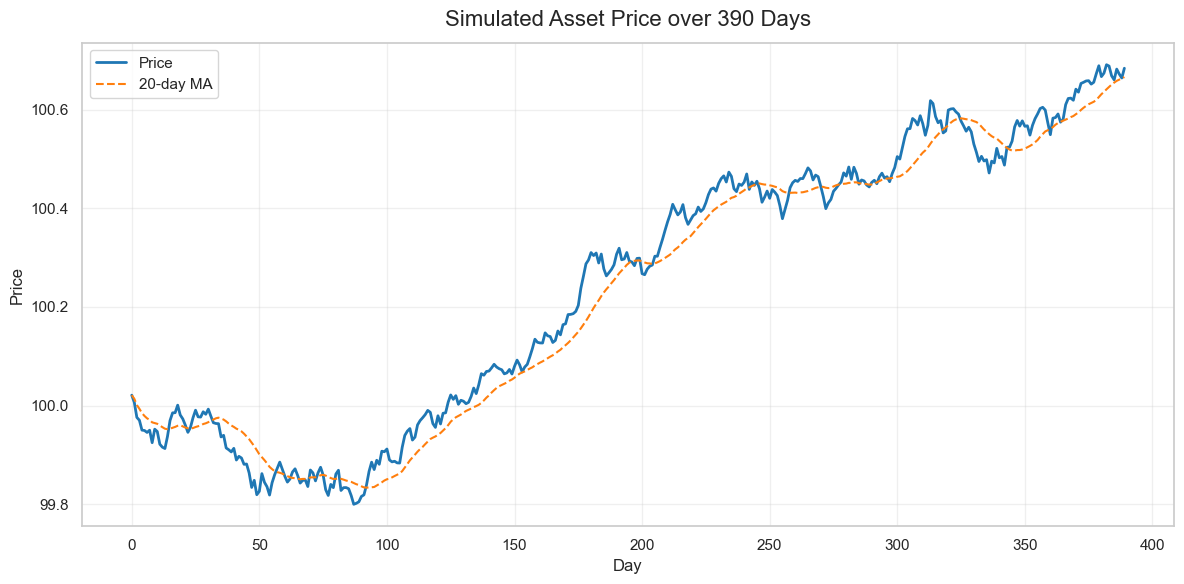

In [4]:
price = simulate_price(f0=100, mu=0.005/390, sigma=0.00015, days=390)
fig, ax = plot_price(
    price=price,
    title="Simulated Asset Price over 390 Days",
    moving_avg_window=20,
    style="seaborn-whitegrid",
    log_scale=False,
    save_path=None
)

### 1.3. Biến số p mô tả ảnh hưởng của đại dịch

#### 1.3.1. Mô tả ảnh hưởng của biến số

Thị trường hoạt động bình thường theo các quy luật chuyển động giá đã xác định. Tuy nhiên, vào mỗi ngày giao dịch, với xác suất $n\%$ có thể xuất hiện một đại dịch duy nhất trong toàn bộ chuỗi mô phỏng.

Trong mô phỏng này chỉ xảy ra tối đa một lần đại dịch. Khi đại dịch khởi phát vào ngày D, nó được đặc trưng bởi hai tham số:
- **Cường độ đại dịch (Intensity I)**: Đo lường mức độ nghiêm trọng của cú sốc lên thị trường. I càng lớn thì tỷ suất sinh lời của các tài sản càng giảm mạnh trong giai đoạn đại dịch.
- **Trường độ đại dịch (Duration L)**: Là số ngày đại dịch duy trì ảnh hưởng. L càng lớn thì thời gian thị trường cần để hồi phục càng dài.

#### 1.3.2. Cơ chế và công thức

##### Cơ chế mô phỏng
Trên mỗi ngày t từ 1 đến N (ví dụ N = 390):
- Sinh ngẫu nhiên sự kiện đại dịch với xác suất $p\%$.
- Nếu sự kiện xảy ra ngày $t = D$, chuyển sang giai đoạn đại dịch.
- Trong giai đoạn đại dịch $(D ≤ t < D + L)$: 
    - Độ lệch trung bình (drift) và độ biến động (volatility) của các tài sản được điều chỉnh giảm theo hàm số của I.
- Sau ngày $D + L$:
    - Thị trường trở lại trạng thái bình thường ban đầu.
    - Mỗi đợt mô phỏng chỉ chứa tối đa một đại dịch, giúp phân tích rõ tác động đơn lẻ của cú sốc cũng như quá trình hồi phục của thị trường.

##### Công thức
Giả sử một sự kiện (ví dụ: đại dịch) bắt đầu vào ngày \( D \), kéo dài \( L \) ngày, với cường độ \( I \). Hàm ảnh hưởng \( p(t) \) được định nghĩa như sau:

$$
p(t) =
\begin{cases}
-I \cdot \sin\left( \pi \cdot \frac{t - D}{L} \right), & \text{nếu } D \le t < D + L \\
0, & \text{ngược lại}
\end{cases}
$$

- **Khởi đầu nhẹ nhàng:**  
  Khi $t = D$, ta có:  

  $$
  \frac{t - D}{L} = 0 \Rightarrow \sin(0) = 0 \Rightarrow p(t) = 0
  $$

  → Tác động bắt đầu một cách êm ái.

- **Kết thúc êm ái:**  
  Khi $t = D + L$, ta có:  

  $$
  \frac{t - D}{L} = 1 \Rightarrow \sin(\pi) = 0 \Rightarrow p(t) = 0
  $$

  → Tác động kết thúc nhẹ nhàng.

- **Đạt đỉnh tác động:**  
  Tại thời điểm giữa sự kiện $t = D + \frac{L}{2}$, ta có:  

  $$
  \frac{t - D}{L} = \frac{1}{2} \Rightarrow \sin\left(\frac{\pi}{2}\right) = 1 \Rightarrow p(t) = -I
  $$

  → Mức tác động tiêu cực lớn nhất.

- **Hình dạng mượt mà:**  
  Sử dụng hàm sin đảm bảo đường cong ảnh hưởng thay đổi liên tục, tăng dần, đạt cực tiểu rồi thoái trào trở về 0 một cách mượt mà và tự nhiên.

#### 1.3.3. Code `Python`

In [15]:
def pandemic_impact(N, p_percent, L, I, seed=None):
    """
    Mô phỏng ảnh hưởng của một đại dịch duy nhất trong N ngày.

    Parameters:
    - N: Tổng số ngày mô phỏng
    - p_percent: Xác suất xảy ra đại dịch mỗi ngày (%)
    - L: Thời gian kéo dài của đại dịch (số ngày)
    - I: Cường độ ảnh hưởng
    - seed: (tuỳ chọn) số nguyên để đặt random seed cho reproducibility

    Returns:
    - impact_array: danh sách chứa ảnh hưởng p(t) tại từng ngày t (1-based)
    """
    if seed is not None:
        random.seed(seed)

    impact_array = []
    pandemic_day = None

    # Xác định ngày khởi phát đại dịch
    for t in range(1, N + 1):
        if pandemic_day is None and random.random() < p_percent / 100:
            pandemic_day = t

        # Tính ảnh hưởng p(t)
        if pandemic_day is not None and pandemic_day <= t < pandemic_day + L:
            fraction = (t - pandemic_day) / L
            pt = -I * math.sin(math.pi * fraction)
        else:
            pt = 0.0

        impact_array.append(pt)

    return impact_array

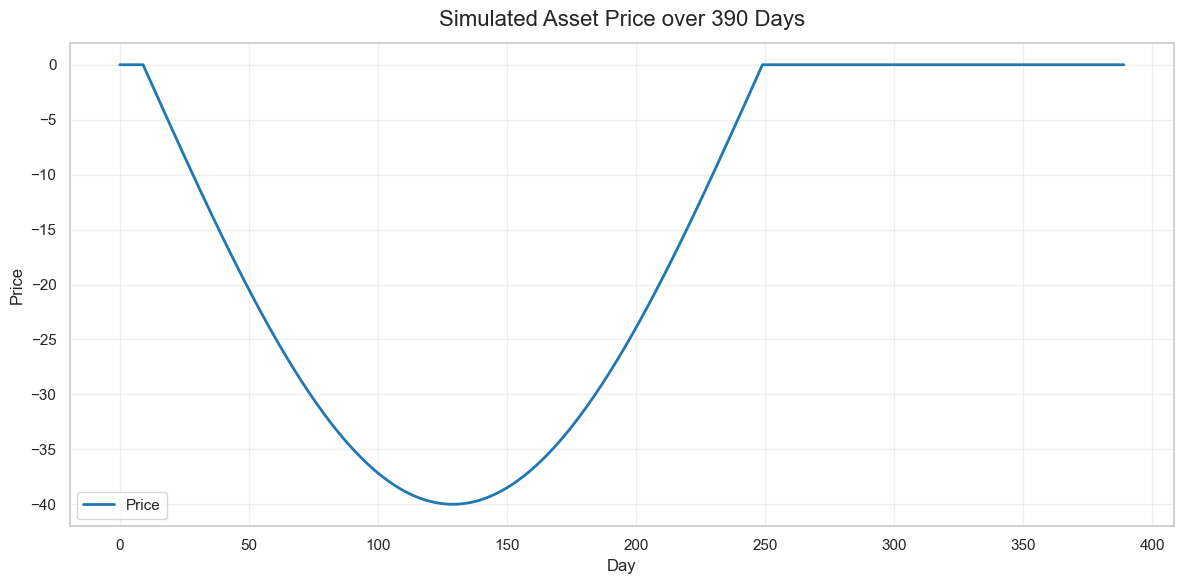

In [42]:
impact = pandemic_impact(N=390, p_percent=1, L=240, I=40)
fig, ax = plot_price(
    price=impact,
    title="Simulated Asset Price over 390 Days",
    moving_avg_window=None,
    style="seaborn-whitegrid",
    log_scale=False,
    save_path=None
)

### 1.4. Phương trình tổng quát

Với $P = f + \alpha p$, ta có module tổng quát sau:

In [43]:
def calculate_P(N, f0, mu, sigma, alpha, p_percent, L, I, epsilon=1e-6):
    """
    Tính toán giá tài sản thực tế (P) dưới tác động của đại dịch,
    sử dụng vòng lặp tường minh để tính P dựa trên từng phần tử của f và p.
    """
    # Bước 1: Tính toán toàn bộ mảng _price (f)
    _price = simulate_price(f0=f0, mu=mu/N, sigma=sigma, days=N)

    # Bước 2: Tính toán toàn bộ mảng _impact (p)
    _impact = pandemic_impact(N=N, p_percent=p_percent, L=L, I=I)

    print(f"Len of _price: {len(_price)}")
    print(f"Len of _impact: {len(_impact)}")

    # Bước 3: Tính toán mảng P bằng vòng lặp tường minh
    P_values = []
    # Kiểm tra kích thước trước khi lặp để đảm bảo an toàn
    if len(_price) != N or len(_impact) != N:
        raise ValueError(f"Kích thước mảng f ({len(_price)}) hoặc p ({len(_impact)}) không khớp với N ({N}).")

    for t in range(N):
        P_t = _price[t] + alpha * _impact[t] # Lấy từng phần tử f[t] và p[t]
        P_values.append(P_t)

    P = np.array(P_values) # Chuyển danh sách P_values thành mảng NumPy

    return P, _price, _impact

In [71]:
def plot_P_and_f(P_values, f_values, title="Biểu đồ Giá tài sản thực tế (P) và Giá lý tưởng (f)"):
    """
    Vẽ biểu đồ của P và f trên cùng một đồ thị.

    Args:
        P_values (np.array): Mảng giá trị P (giá thực tế).
        f_values (np.array): Mảng giá trị f (giá lý tưởng, tức _price).
        title (str, optional): Tiêu đề của biểu đồ.
    """
    # Đảm bảo cả hai mảng có cùng độ dài
    N = len(P_values)
    if len(f_values) != N:
        print("Cảnh báo: Các mảng P và f có độ dài khác nhau. Biểu đồ có thể không chính xác.")
        N = min(N, len(f_values))
        P_values = P_values[:N]
        f_values = f_values[:N]

    days = np.arange(N) # Tạo trục x

    plt.figure(figsize=(14, 7)) # Kích thước biểu đồ lớn hơn để dễ nhìn
    plt.plot(days, P_values, label='P (Giá thực tế)', color='blue', linewidth=2)
    plt.plot(days, f_values, label='f (Giá lý tưởng)', color='green', linestyle='--')

    plt.title(title)
    plt.xlabel('Ngày')
    plt.ylabel('Giá trị')
    plt.legend() # Hiển thị chú giải
    plt.grid(True) # Bật lưới
    plt.tight_layout() # Điều chỉnh bố cục để mọi thứ vừa vặn
    plt.show()

Len of _price: 390
Len of _impact: 390


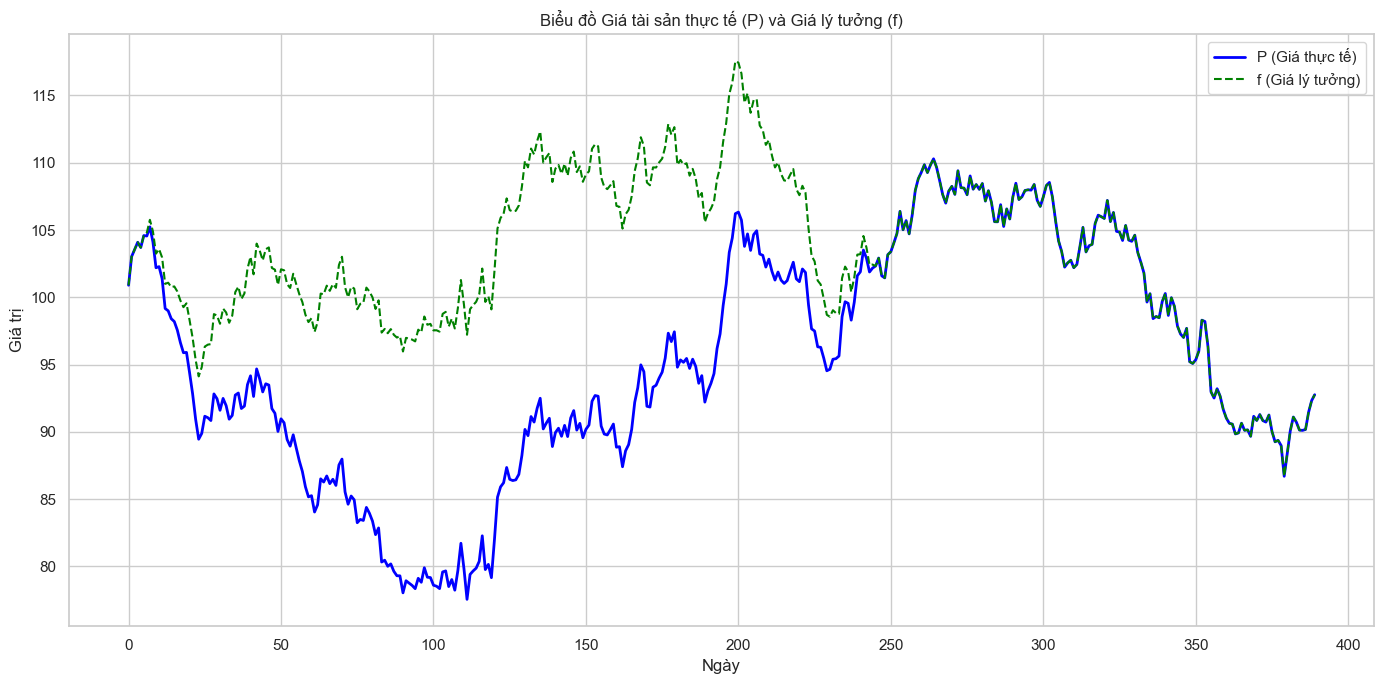

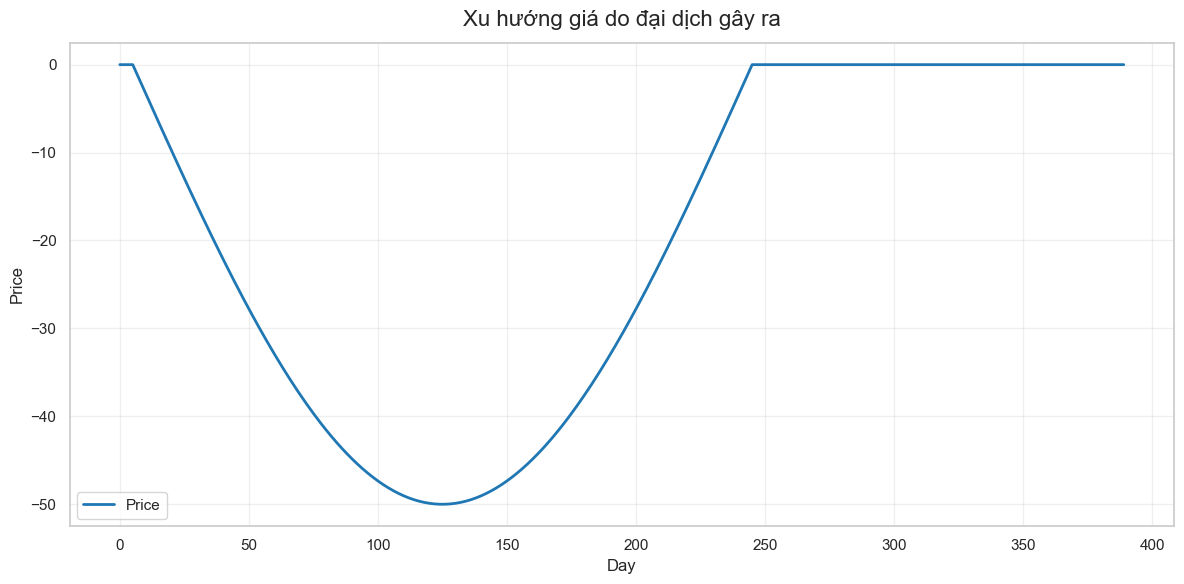

In [73]:
N_days = 390          # Tổng số ngày mô phỏng
initial_f = 100.0     # Giá tài sản ban đầu lý tưởng
daily_mu = 0.02     # Tỷ suất sinh lời kỳ vọng hàng năm (2%)
daily_sigma = 0.01    # Độ biến động hàng ngày (1%)

alpha_sensitivity = 0.4 # Hệ số nhạy cảm với đại dịch (alpha)
p_max_percent = 1     # Tỉ lệ xuất hiện đại dịch tại ngày bất kỳ (1 tương ứng với 1%)
L_phase = 240         # Giai đoạn tác động ban đầu của đại dịch (ngày)
I_phase = 50          # Cường độ đại dịch

# Tính toán mảng P
P_simulation, f_simulation, p_simulation = calculate_P(
    N=N_days,
    f0=initial_f,
    mu=daily_mu,
    sigma=daily_sigma,
    alpha=alpha_sensitivity,
    p_percent=p_max_percent,
    L=L_phase,
    I=I_phase
)

plot_P_and_f(P_simulation, f_simulation)

fig, ax = plot_price(
    price=p_simulation,
    title="Xu hướng giá do đại dịch gây ra",
    moving_avg_window=None,
    style="seaborn-whitegrid",
    log_scale=False,
    save_path=None
)